In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingClassifier

from xgboost import XGBRegressor, plot_tree

from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV

In [3]:
df = pd.read_csv('../inputs/train.csv')

In [4]:
global_filter = (df['return'] < 0.1) & (df['pf_category'] != 'E') & (df['type'] != 'G') & (df['bought'] < 1e10)

In [5]:
df = df.loc[global_filter, :]

In [6]:
df['indicator_code'] = df['indicator_code'].isnull().apply(lambda x: int(x))
hedge_value_dict = {True:1, False:0}
df['hedge_value'] = df['hedge_value'].apply(lambda x: hedge_value_dict[x] if x in hedge_value_dict else 2)

In [7]:
df['has_desk_id'] = df['desk_id'].isnull().apply(lambda x: int(x))
df['has_hedge_value'] = df['hedge_value'].apply(lambda x: 0 if x != 2 else 2)
df['status'] = df['status'].apply(lambda x: 1 if x == True else 0)

In [8]:
df['sell_year'] = df['sell_date'].apply(lambda x: x//10000)
df['sell_month'] = df['sell_date'].apply(lambda x: (x//100)%100)
df['sold_bought'] = df['sold'] - df['bought']

In [9]:
df_grouping = {}

In [10]:
print (df.columns)

Index(['portfolio_id', 'desk_id', 'office_id', 'pf_category', 'start_date',
       'sold', 'country_code', 'euribor_rate', 'currency', 'libor_rate',
       'bought', 'creation_date', 'indicator_code', 'sell_date', 'type',
       'hedge_value', 'status', 'return', 'has_desk_id', 'has_hedge_value',
       'sell_year', 'sell_month', 'sold_bought'],
      dtype='object')


In [11]:
for var_to_group in ['pf_category', 'country_code', 'type', 'indicator_code', 'hedge_value',\
                     'status', 'sell_year', 'sell_month']:
    print (var_to_group)
    df_grouping[var_to_group] = df.groupby([var_to_group])\
                                  .agg({'return':[np.mean, np.median, np.max, np.min, 'count']})
                                  # .reset_index()
    # print (df_grouping[var_to_group].index.name)
    # print (df_grouping[var_to_group].columns)
    new_col_names =  [df_grouping[var_to_group].index.name] + ['_'.join([df_grouping[var_to_group].index.name] + list(x)) \
                      for x in (df_grouping[var_to_group].columns.ravel())]
    # print (new_col_names)
    df_grouping[var_to_group].reset_index(inplace = True)
    df_grouping[var_to_group].columns = new_col_names
    # df_grouping[var_to_group].columns = df_grouping[var_to_group].columns.get_level_values(0)
    # print (df_grouping[var_to_group].columns)
    # print (df_grouping[var_to_group])
    for col in df_grouping[var_to_group].columns:
        if '_count' in col:
            df_grouping[var_to_group][col] = df_grouping[var_to_group][col]/len(df)

    df = pd.merge(left = df, right = df_grouping[var_to_group], on = var_to_group, how = 'left')

pf_category
country_code
type
indicator_code
hedge_value
status
sell_year
sell_month


In [12]:
print (df.dtypes)

portfolio_id                     object
desk_id                          object
office_id                        object
pf_category                      object
start_date                        int64
sold                            float64
country_code                     object
euribor_rate                    float64
currency                         object
libor_rate                      float64
bought                          float64
creation_date                     int64
indicator_code                    int64
sell_date                         int64
type                             object
hedge_value                       int64
status                            int64
return                          float64
has_desk_id                       int64
has_hedge_value                   int64
sell_year                         int64
sell_month                        int64
sold_bought                     float64
pf_category_return_mean         float64
pf_category_return_median       float64


In [13]:
df['euribor_rate'].fillna(df['euribor_rate'].median(), inplace = True)
df['libor_rate'].fillna(df['libor_rate'].median(), inplace = True)
df['desk_id'].fillna('NA', inplace = True)

In [21]:
print (df.dtypes.isin([np.float64]))

portfolio_id                    False
desk_id                         False
office_id                       False
pf_category                     False
start_date                      False
sold                            False
country_code                    False
euribor_rate                    False
currency                        False
libor_rate                      False
bought                          False
creation_date                   False
indicator_code                  False
sell_date                       False
type                            False
hedge_value                     False
status                          False
return                          False
has_desk_id                     False
has_hedge_value                 False
sell_year                       False
sell_month                      False
sold_bought                     False
pf_category_return_mean         False
pf_category_return_median       False
pf_category_return_amax         False
pf_category_

In [14]:
# xgboost parameter tuning

In [23]:
input_cols_xgb_encode = ['office_id', 'pf_category', 'country_code', 'type'] 
input_cols_xgb_numeric = df.dtypes[(df.dtypes == np.int64) | (df.dtypes == np.float64)].index.tolist()
# print (input_cols_xgb_numeric)
input_cols_xgb_numeric.remove('return')
target_cols_xgb = ['return']

In [24]:
print (input_cols_xgb_numeric)

['start_date', 'sold', 'euribor_rate', 'libor_rate', 'bought', 'creation_date', 'indicator_code', 'sell_date', 'hedge_value', 'status', 'has_desk_id', 'has_hedge_value', 'sell_year', 'sell_month', 'sold_bought', 'pf_category_return_mean', 'pf_category_return_median', 'pf_category_return_amax', 'pf_category_return_amin', 'pf_category_return_count', 'country_code_return_mean', 'country_code_return_median', 'country_code_return_amax', 'country_code_return_amin', 'country_code_return_count', 'type_return_mean', 'type_return_median', 'type_return_amax', 'type_return_amin', 'type_return_count', 'indicator_code_return_mean', 'indicator_code_return_median', 'indicator_code_return_amax', 'indicator_code_return_amin', 'indicator_code_return_count', 'hedge_value_return_mean', 'hedge_value_return_median', 'hedge_value_return_amax', 'hedge_value_return_amin', 'hedge_value_return_count', 'status_return_mean', 'status_return_median', 'status_return_amax', 'status_return_amin', 'status_return_count', 

In [25]:
X_xgb = df[input_cols_xgb_encode + input_cols_xgb_numeric].as_matrix()
label_enc = [LabelEncoder() for i in range(len(input_cols_xgb_encode))]

for i in range(len(label_enc)):
    print (input_cols_xgb_encode[i])
    label_enc[i].fit(X_xgb[:, i])
    X_xgb[:, i] = label_enc[i].transform(X_xgb[:, i])

y_xgb = df[target_cols_xgb].as_matrix()

office_id
pf_category
country_code
type


In [28]:
# get the optimum no of trees for learning rate of 0.1
parameters = {'n_estimators' : [10, 50, 100, 150, 200, 250, 500]}
xgb_reg = XGBRegressor(random_state=42)
clf = GridSearchCV(xgb_reg, parameters, cv = 3, scoring = 'r2')
clf.fit(X_xgb, y_xgb)
print (clf.best_params_)

{'n_estimators': 200}


In [29]:
pd.DataFrame(clf.cv_results_)
# take 200 trees as the optimum number for now

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_n_estimators,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,0.082728,0.006354,-420.546320,-101.193229,10,{'n_estimators': 10},7,-49.415194,-164.055446,-93.436154,-77.333211,-1119.011553,-62.191030,0.005315,0.004022,494.137271,44.878095
1,0.317845,0.006517,0.408810,0.947391,50,{'n_estimators': 50},6,0.215982,0.944098,0.933016,0.942945,0.077325,0.955130,0.025563,0.001084,0.374996,0.005493
2,0.703956,0.011530,0.440948,0.976554,100,{'n_estimators': 100},5,0.161055,0.985433,0.966057,0.969359,0.195655,0.974870,0.053722,0.001785,0.371606,0.006669
3,0.934315,0.014372,0.458961,0.979360,150,{'n_estimators': 150},4,0.165317,0.987562,0.965779,0.973169,0.245718,0.977348,0.040039,0.000626,0.359903,0.006046
4,1.182500,0.019553,0.482377,0.980689,200,{'n_estimators': 200},1,0.229711,0.987946,0.965543,0.975213,0.251803,0.978909,0.039225,0.002556,0.341797,0.005348
5,1.525731,0.027896,0.480679,0.981037,250,{'n_estimators': 250},2,0.223695,0.988056,0.965539,0.975629,0.252729,0.979426,0.074521,0.007745,0.343080,0.005200
6,2.801490,0.032921,0.479362,0.981196,500,{'n_estimators': 500},3,0.219745,0.988107,0.965539,0.975939,0.252729,0.979541,0.040583,0.002896,0.344070,0.005104


In [30]:
# now tune the max_depth and min_child_weight
parameters = {
 'max_depth':range(3,10,2),
 'min_child_weight':range(1,6,2)
}
xgb_reg = XGBRegressor(random_state=42, learning_rate = 0.1, n_estimators = 200)
clf = GridSearchCV(xgb_reg, parameters, cv = 3, scoring = 'r2')
clf.fit(X_xgb, y_xgb)
print (clf.best_params_)

{'max_depth': 5, 'min_child_weight': 1}


In [31]:
pd.DataFrame(clf.cv_results_)

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_max_depth,param_min_child_weight,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,1.333236,0.018716,0.482377,0.980689,3,1,"{'max_depth': 3, 'min_child_weight': 1}",3,0.229711,0.987946,0.965543,0.975213,0.251803,0.978909,0.160905,0.000947,0.341797,0.005348
1,1.227346,0.017382,0.445351,0.981016,3,3,"{'max_depth': 3, 'min_child_weight': 3}",7,0.124797,0.988913,0.968023,0.975942,0.243167,0.978194,0.100648,0.000626,0.372760,0.005659
2,1.148464,0.019375,0.420186,0.980671,3,5,"{'max_depth': 3, 'min_child_weight': 5}",8,0.056560,0.987735,0.965060,0.975746,0.238881,0.978531,0.012245,0.000860,0.392437,0.005123
3,1.795918,0.022572,0.549120,0.990334,5,1,"{'max_depth': 5, 'min_child_weight': 1}",1,0.446040,0.992286,0.964814,0.988490,0.236406,0.990225,0.035752,0.004621,0.306167,0.001551
4,1.817431,0.024239,0.475706,0.989838,5,3,"{'max_depth': 5, 'min_child_weight': 3}",4,0.181076,0.992135,0.949113,0.988334,0.296871,0.989044,0.034287,0.004392,0.338098,0.001650
5,1.814201,0.024398,0.445938,0.988466,5,5,"{'max_depth': 5, 'min_child_weight': 5}",6,0.068233,0.990038,0.965832,0.987685,0.303705,0.987675,0.054948,0.007046,0.380009,0.001111
6,2.475634,0.025590,0.494213,0.994608,7,1,"{'max_depth': 7, 'min_child_weight': 1}",2,0.270376,0.992854,0.947598,0.995263,0.264592,0.995707,0.037540,0.009694,0.320626,0.001253
7,2.438971,0.025566,0.374179,0.992531,7,3,"{'max_depth': 7, 'min_child_weight': 3}",11,-0.060164,0.992487,0.943189,0.992622,0.239470,0.992484,0.054513,0.007198,0.420565,0.000064
8,2.396100,0.029090,0.416092,0.991056,7,5,"{'max_depth': 7, 'min_child_weight': 5}",9,0.018426,0.990872,0.950862,0.991599,0.278943,0.990695,0.058911,0.010252,0.392840,0.000391
9,2.481369,0.023072,0.459825,0.996360,9,1,"{'max_depth': 9, 'min_child_weight': 1}",5,0.225109,0.995767,0.900107,0.996104,0.254194,0.997209,0.410769,0.006575,0.311577,0.000616


In [32]:
# check the values in the neighbourhood of the above values
parameters = {
 'max_depth':[4, 5, 6],
 'min_child_weight':[1,2]
}
xgb_reg = XGBRegressor(random_state=42, learning_rate = 0.1, n_estimators = 200)
clf = GridSearchCV(xgb_reg, parameters, cv = 3, scoring = 'r2')
clf.fit(X_xgb, y_xgb)
print (clf.best_params_)

{'max_depth': 5, 'min_child_weight': 1}


In [33]:
# tune the value of gamma
parameters = {
 'gamma':[x/10.0 for x in range(6)]
}
xgb_reg = XGBRegressor(random_state=42, learning_rate = 0.1, n_estimators = 200, \
                       max_depth = 5, min_child_weight = 1)
clf = GridSearchCV(xgb_reg, parameters, cv = 3, scoring = 'r2')
clf.fit(X_xgb, y_xgb)
print (clf.best_params_)

{'gamma': 0.0}


In [34]:
# tune the value of subsample and colsample_bytree
parameters = {
 'subsample':[x/10.0 for x in range(6,11)],
 'colsample_bytree':[x/10.0 for x in range(6,11)]
}
xgb_reg = XGBRegressor(random_state=42, learning_rate = 0.1, n_estimators = 200, \
                       max_depth = 5, min_child_weight = 1, gamma = 0)
clf = GridSearchCV(xgb_reg, parameters, cv = 3, scoring = 'r2')
clf.fit(X_xgb, y_xgb)
print (clf.best_params_)

{'colsample_bytree': 0.8, 'subsample': 1.0}


In [36]:
# tune the value of subsample and colsample_bytree with more tight intervals
parameters = {
 'colsample_bytree':[0.75, 0.8, 0.85],
 'subsample':[0.95, 1.0]
}
xgb_reg = XGBRegressor(random_state=42, learning_rate = 0.1, n_estimators = 200, \
                       max_depth = 5, min_child_weight = 1, gamma = 0)
clf = GridSearchCV(xgb_reg, parameters, cv = 3, scoring = 'r2')
clf.fit(X_xgb, y_xgb)
print (clf.best_params_)

{'colsample_bytree': 0.8, 'subsample': 1.0}


In [39]:
# tune regularization value alpha
parameters = {
 'reg_alpha':[0, 1e-5, 1e-2, 0.1, 1, 100]
}
xgb_reg = XGBRegressor(random_state=42, learning_rate = 0.1, n_estimators = 200, \
                       max_depth = 5, min_child_weight = 1, gamma = 0, \
                       colsample_bytree = 0.8, subsample = 1.0)
clf = GridSearchCV(xgb_reg, parameters, cv = 3, scoring = 'r2')
clf.fit(X_xgb, y_xgb)
print (clf.best_params_)

{'reg_alpha': 0}


In [40]:
# tune the learning rate
parameters = {
 'learning_rate':[0.001, 0.01, 0.05, 0.1, 0.3]
}
xgb_reg = XGBRegressor(random_state=42, n_estimators = 500, \
                       max_depth = 5, min_child_weight = 1, gamma = 0, \
                       colsample_bytree = 0.8, subsample = 1.0, reg_alpha = 0)
clf = GridSearchCV(xgb_reg, parameters, cv = 3, scoring = 'r2')
clf.fit(X_xgb, y_xgb)
print (clf.best_params_)

{'learning_rate': 0.05}


In [26]:
# train the final classifier
xgb_reg = XGBRegressor(random_state=42, learning_rate = 0.05, n_estimators = 1000, \
                       max_depth = 5, min_child_weight = 1, gamma = 0, \
                       colsample_bytree = 0.8, subsample = 1.0, reg_alpha = 0)
xgb_reg.fit(X_xgb, y_xgb)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=1000,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=42,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1.0)

In [27]:
y_xgb_pred = xgb_reg.predict(X_xgb)
print (r2_score(y_xgb, y_xgb_pred))

0.996348888112


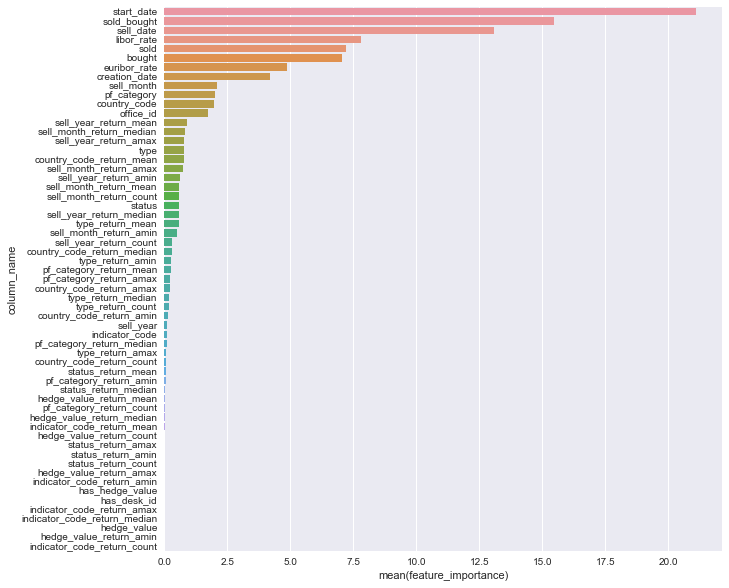

In [28]:
# plot the feature importances
df_feature_importance = pd.DataFrame(list(zip((input_cols_xgb_encode + input_cols_xgb_numeric), \
                                              xgb_reg.feature_importances_)),\
                                     columns = ['column_name', 'feature_importance'])
df_feature_importance = df_feature_importance.sort_values(by = 'feature_importance', ascending = False).reset_index()
df_feature_importance['feature_importance'] *= 100
fig, axs = plt.subplots(nrows = 1, ncols = 1, figsize=(10 , 10))
sns.barplot(x = 'feature_importance', y = 'column_name', data = df_feature_importance)

ExecutableNotFound: failed to execute ['dot', '-Tpng'], make sure the Graphviz executables are on your systems' PATH

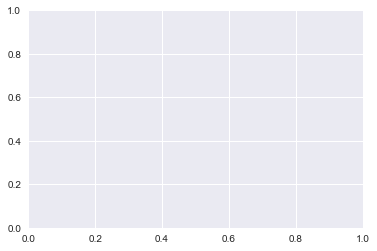

In [29]:
# plot the tree
plot_tree(xgb_reg)

In [35]:
# make predictions on the test set
df_test = pd.read_csv('../inputs/test.csv')

df_test['indicator_code'] = df_test['indicator_code'].isnull().apply(lambda x: int(x))
df_test['hedge_value'] = df_test['hedge_value'].apply(lambda x: hedge_value_dict[x] if x in hedge_value_dict else 2)

df_test['has_desk_id'] = df_test['desk_id'].isnull().apply(lambda x: int(x))
df_test['has_hedge_value'] = df_test['hedge_value'].apply(lambda x: 0 if x != 2 else 2)
df_test['status'] = df_test['status'].apply(lambda x: 1 if x == True else 0)

df_test['sell_year'] = df_test['sell_date'].apply(lambda x: x//10000)
df_test['sell_month'] = df_test['sell_date'].apply(lambda x: (x//100)%100)
df_test['sold_bought'] = df_test['sold'] - df_test['bought']

df_test['euribor_rate'].fillna(df['euribor_rate'].median(), inplace = True)
df_test['libor_rate'].fillna(df['libor_rate'].median(), inplace = True)
df_test['desk_id'].fillna('NA', inplace = True)

In [36]:
(df_test['desk_id'] == 'NA').sum()

1948

In [37]:
if ['desk_id'] in input_cols_xgb_encode:
    desk_id_list = set(label_enc[input_cols_xgb_encode.index('desk_id')].classes_.tolist())
    df_test['desk_id'] = df_test['desk_id'].apply(lambda x: 'NA' if x not in desk_id_list else x)

In [38]:
(df_test['desk_id'] == 'NA').sum()

1948

In [39]:
for var_to_group in df_grouping.keys():
    df_test = pd.merge(left = df_test, right = df_grouping[var_to_group], on = var_to_group, how = 'left')

In [40]:
print (df_test.columns)

Index(['portfolio_id', 'desk_id', 'office_id', 'pf_category', 'start_date',
       'sold', 'country_code', 'euribor_rate', 'currency', 'libor_rate',
       'bought', 'creation_date', 'indicator_code', 'sell_date', 'type',
       'hedge_value', 'status', 'has_desk_id', 'has_hedge_value', 'sell_year',
       'sell_month', 'sold_bought', 'pf_category_return_mean',
       'pf_category_return_median', 'pf_category_return_amax',
       'pf_category_return_amin', 'pf_category_return_count',
       'country_code_return_mean', 'country_code_return_median',
       'country_code_return_amax', 'country_code_return_amin',
       'country_code_return_count', 'type_return_mean', 'type_return_median',
       'type_return_amax', 'type_return_amin', 'type_return_count',
       'indicator_code_return_mean', 'indicator_code_return_median',
       'indicator_code_return_amax', 'indicator_code_return_amin',
       'indicator_code_return_count', 'hedge_value_return_mean',
       'hedge_value_return_median', 

In [41]:
# make predictions on the test set with the optimum parameters
X_xgb_test = df_test[input_cols_xgb_encode + input_cols_xgb_numeric].as_matrix()

for i in range(len(label_enc)):
    X_xgb_test[:, i] = label_enc[i].transform(X_xgb_test[:, i])

df_submit = pd.DataFrame(df_test['portfolio_id'])
df_submit['return'] = xgb_reg.predict(X_xgb_test)

df_submit.to_csv('../submissions/submit_20171217_1940_xgb.csv', index=False)
